Michael Ricardo DS 2500 Project Trading torch

In [1164]:
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.model_selection import train_test_split

In [1165]:
def fetch_ticker_data(ticker):
    """
    Gets the market data for a given date and ticker.
    Fetches from yfinance library.

    Args:
        years ago (int): Representing the most recent day for stock entries 
        ticker(str): Representing the offical company stock ticker
    Returns
        df (DataFrame): DataFrame with Stock pricing data and history data
    """
    most_recent = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
    start_date = '2014-12-01'
    
    
    stock_data = yf.Ticker(ticker)
    returning_data = stock_data.history(start = start_date, end= most_recent)
    
    returning_data.index = returning_data.index.tz_localize(None).normalize()

    return returning_data

In [1166]:
#Data for the TNX, Ten Year
ticker = '^TNX'
Ten_Year = fetch_ticker_data(ticker)
Ten_Year = Ten_Year.drop(columns=['Open','Dividends', 'Stock Splits', 'Volume'])
Ten_Year = Ten_Year.rename(columns={'High': '10_year_high', 'Low': '10_year_low', 'Close': '10_year_close'})

Adding variables not related to security itself: 

In [1167]:
#Data for the S&P 500 
ticker = '^GSPC'
SP500 = fetch_ticker_data(ticker)
SP500['SP500_SMA_14'] = ta.sma(SP500['Close'], length=14) 
SP500 = SP500.drop(columns=['Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'Volume', 'Close'])

In [1168]:
#VIX Data
ticker = '^VIX'
VIX = fetch_ticker_data(ticker)
VIX['VIX_SMA_14'] = ta.sma(VIX['Close'], length=14) 
VIX = VIX.drop(columns=['Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'Volume', 'Close'])

In [1169]:
def external_csv(csv):
    '''
    Pulling in a csv, setting the 'Date column as the index and making it a proper datetime object
    Args:
        csv (CSV) - Data collection with Date column along with pricing data 
    Returns
        df (DataFrame): DataFrame     
    '''
    csv_read = pd.read_csv(csv)
    
    return csv_read

In [1170]:
#CPI data CSV
cpi_csv = 'CPI_Data_10.csv'
cpi = external_csv(cpi_csv)
cpi = cpi.rename(columns={'Close': 'CPI_close'})
cpi = cpi.set_index('Date')
cpi['CPI_close'] = cpi['CPI_close'].fillna(method='ffill') #Got this part off stack overflow # fix CPI

/tmp/ipykernel_67238/4201308916.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cpi['CPI_close'] = cpi['CPI_close'].fillna(method='ffill') #Got this part off stack overflow # fix CPI


In [1171]:
one_year_csv = '1year_bond_master.csv'
One_Year = external_csv(one_year_csv)
One_Year = One_Year.drop(columns=['Open', 'High', 'Low'])

In [1172]:
#Further cleaning needed for the 1 year, flipping the rows, eliminating % sign within each
One_Year = One_Year.iloc[::-1] 
One_Year['Close'] = One_Year['Close'].str.rstrip('%').astype(float)

One_Year = One_Year.rename(columns={'Close': '1_year_close'})
One_Year = One_Year.set_index('Date')

Section will be for data curration and preperation for regression 

In [1173]:
def security_editor(df, close_col, high_col,low_col):
    """
    Gaining volatility and moving index metrics from the bond, bill, or note functioning as df. Yield Volatilioty represents the historical volatility for an asset over a given
    time though its Standerd deviation. Simple moving average measures the average closing price for a week & month of an asset. 

    Args:
        df (dataframe): Specific asset df imported with Close, Volume, High, and Low data for each day of market activity 
    Returns
        df(dataframe): Added ATR. SMA_7 and SMA_30 cols for given securuity. Removing high and low cols
    """
    df['Yield_STDEV'] = ta.stdev(df[close_col], length = 14)
    df = df.drop(columns=[high_col, low_col])
    
    
    return df

In [1174]:
df = Ten_Year
close_col = '10_year_close'
high_col = '10_year_high'
low_col = '10_year_low'
Ten_Year_Complete = security_editor(Ten_Year, close_col, high_col, low_col)
Ten_Year_Complete

,10_year_close,Yield_STDEV
Date,,
2014-12-01,2.218,NaN
2014-12-02,2.285,NaN
2014-12-03,2.287,NaN
2014-12-04,2.257,NaN
2014-12-05,2.307,NaN
...,...,...
2024-11-22,4.410,0.054405
2024-11-25,4.265,0.058041
2024-11-26,4.302,0.060994


In [1175]:

def combine(df_first, dfs):
    """
    Combining the data from other indexes to be used as variabels
    Args:
        df_main (dataframe): Main secuirty which will have the others cols added
        df_1 (dataframe): Sub index which will be added to df_main, will be used for S&P 500
        df_2 (dataframe): Sub index which will be added to df_main, will be used for VIx 
    Returns:
        df_mained: Combined df_main with df1 & df2
    """
    for df in dfs:
        # Ensure indices are aligned and consistent
        df.index = pd.to_datetime(df.index)
        df_first = pd.concat([df_first, df], axis=1)
    return df_first


In [1176]:
#merging the dfs from above into the 10 year bond
dfs = [SP500, VIX, Five_Year, One_Year, cpi, Thirteen_Week]
df_first = Ten_Year_Complete
final_df = combine(df_first, dfs)

In [1177]:
#Quickly Creating Yield Spread for Analysis
final_df['Short_Term_Spread'] = final_df['10_year_close'] - final_df['1_year_close']

In [1178]:
#Checking correlation for what to add
final_df.corr()

,10_year_close,Yield_STDEV,SP500_SMA_14,VIX_SMA_14,5_year_close,1_year_close,CPI_close,13_week_close,Short_Term_Spread
10_year_close,1.000000,0.311329,0.485003,-0.286360,0.987559,0.918672,0.649948,0.888746,-0.648829
Yield_STDEV,0.311329,1.000000,0.261062,0.316457,0.346089,0.341501,0.378771,0.311588,-0.312032
SP500_SMA_14,0.485003,0.261062,1.000000,0.117450,0.519749,0.589504,0.932784,0.620074,-0.595400
VIX_SMA_14,-0.286360,0.316457,0.117450,1.000000,-0.224865,-0.145502,0.100333,-0.167719,-0.042615
5_year_close,0.987559,0.346089,0.519749,-0.224865,1.000000,0.955574,0.704040,0.919281,-0.733932
1_year_close,0.918672,0.341501,0.589504,-0.145502,0.955574,1.000000,0.780995,0.987073,-0.896646
CPI_close,0.649948,0.378771,0.932784,0.100333,0.704040,0.780995,1.000000,0.783325,-0.782306
13_week_close,0.888746,0.311588,0.620074,-0.167719,0.919281,0.987073,0.783325,1.000000,-0.905963
Short_Term_Spread,-0.648829,-0.312032,-0.595400,-0.042615,-0.733932,-0.896646,-0.782306,-0.905963,1.000000


In [1179]:
final_df = final_df.dropna(subset=['10_year_close', 'SP500_SMA_14','1_year_close', 'Yield_STDEV'])
final_df

,10_year_close,Yield_STDEV,SP500_SMA_14,VIX_SMA_14,5_year_close,1_year_close,CPI_close,13_week_close,Short_Term_Spread
Date,,,,,,,,,
2014-12-18,2.204,0.073750,2040.145011,16.662143,1.659,0.25,NaN,0.033,1.954000e+00
2014-12-19,2.176,0.073878,2041.374294,16.828572,1.654,0.25,NaN,0.025,1.926000e+00
2014-12-22,2.162,0.070003,2042.230722,17.000000,1.659,0.26,NaN,0.015,1.902000e+00
2014-12-23,2.257,0.067196,2042.790710,17.164286,1.727,0.25,NaN,0.020,2.007000e+00
2014-12-24,2.264,0.067777,2043.502136,17.306429,1.759,0.25,NaN,0.020,2.014000e+00
...,...,...,...,...,...,...,...,...,...
2024-11-20,4.406,0.056236,5902.867850,16.714286,4.275,4.37,NaN,4.410,3.600014e-02
2024-11-21,4.432,0.057928,5918.575718,16.356429,4.305,4.39,NaN,4.413,4.200016e-02
2024-11-22,4.410,0.054405,5936.907854,15.875000,4.298,4.41,NaN,4.415,-1.525879e-07


Regressions:

In [1180]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")
    return Xnew

In [1181]:
from sklearn.metrics import mean_squared_error, r2_score
def linreg_predict(features, dependent, df):
    """Predicts vals for a given array, and returns dct of mse and r^2
    Args:
        Xnew: (an array, either 1-d or 2-d which includes all the $p$ predictor features, not including bias term)
        ynew: (a 1-d array which includes all corresponding response values to `Xnew`)
        m: (a 1-d array of length $p+1$ which contains the coefficients from the `line_of_best_fit` function)
    Returns:
        dct: dictionary, dct of mse and r^2 vals
    """

    features_df = df[features]
    target_series = df[dependent]
    X_train, X_test, y_train, y_test = train_test_split(features_df, target_series, random_state=30, test_size = 0.3)
    linear_regression_model = LinearRegression()
    linear_regression_model.fit(X_train, y_train)
    
    predictions = linear_regression_model.predict(X_test)
    rmse = np.sqrt(((predictions - y_test) ** 2).mean())
    
    residuals = y_test - predictions
    dct = {}
    
    
    dct["ypreds"] = predictions
    dct["resids"] = residuals
    dct["mse"] = rmse
    dct["r2"] = r2_score(y_test, dct["ypreds"])

    return dct

In [1182]:
m = linreg_predict(features=['SP500_SMA_14', 'VIX_SMA_14', 'Yield_STDEV', 'Short_Term_Spread'], dependent='10_year_close', df=final_df)

In [1183]:
m

{'ypreds': array([2.03457652, 1.98087932, 2.28153714, 2.6905323 , 3.46565143,
        3.58251674, 2.35666478, 3.22022936, 2.15466953, 3.72801742,
        2.42452234, 2.62457238, 2.11510271, 2.40993651, 2.1441247 ,
        3.82443599, 2.61761484, 2.68421122, 3.81477629, 2.01801402,
        2.19195597, 3.23640858, 3.75035607, 3.02373968, 1.90190733,
        2.68457314, 1.59165303, 3.82561395, 1.72427013, 3.58025993,
        2.34103299, 3.4459313 , 1.38212681, 3.98515941, 3.35022564,
        2.24884497, 2.62103123, 1.81605971, 3.86633253, 2.0901556 ,
        1.98920498, 2.33684531, 1.42948611, 2.7285743 , 1.88446104,
        2.96120762, 3.81115449, 2.47200161, 2.10463072, 3.8761417 ,
        1.86778019, 2.32939674, 2.11678756, 2.65335257, 2.69697842,
        2.71900689, 2.59678504, 1.98228655, 2.23828216, 2.11189675,
        1.8154219 , 1.74787645, 4.20368193, 2.47085914, 1.66226812,
        1.79528985, 3.58324232, 2.47799535, 2.5193645 , 1.60359697,
        1.42645089, 2.33025521, 2.6663

In [1184]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [1185]:
def line_of_best_fit(X, y):
    '''
    This function computes the line of best fit by providing the coefficients for the slope(s) 
    and intercept using the Ordinary Least Squares (OLS) method. It achieves this by projecting 
    the values of y onto the span of X (the space defined by the independent variables).
    
    X represents out input data, a numpy array, and acts as out indepedet variable. y represents the data we 
    are trying to predict, a numpy array of the same length as X, and acts as our as a dependent variable.
    
    Output = Coefficants as an array, first elm being the intercept accounted for with the 'add_bias_column' 
    and second being the intercept. Can be summarized as the line of best foit for predicted y values on X.
    '''
    proper_X = add_bias_column(X)
    
    vector = np.matmul(np.linalg.inv(np.matmul(proper_X.T, proper_X)), np.matmul(proper_X.T, y))
       
    return vector

In [1186]:
def linreg_predict(Xnew, ynew, m):
    '''
    This function is used to gage the predicted values, residual values, MSE (Mean Squared Error), and r2_score to analysze a
    line of best fit projecttion,
    
    Xnew is either a 1D or 2D array which is the data used as 'predictor fatures' in predicitng y. Does not contain a bias column
    Ynew is a 1d array and can be summrized as the values given by multiple Xnew and m
    M is a 1d arrat represented as the found coeffeicint line of best fit values for the given data within the lin_of_best function
    
    Output = dct with ypreds, resids, mse, and r2 as a measurement of the current predicted values of y compared to the true
    values. 
    
    '''
    proper_X = add_bias_column(Xnew)
    
    ypreds = np.matmul(proper_X, m)
    
    resids = ynew - ypreds
    
    mse = np.mean(resids**2)
    
    r2 = r2_score(ynew, ypreds)
    
    final_dct = {
        'ypreds': ypreds,
        'resids': resids,
        'mse': mse,
        'r2': r2        
    }
    
    
    return final_dct

In [1187]:
x = final_df[['SP500_SMA_14', 'VIX_SMA_14', 'Yield_STDEV', 'Short_Term_Spread']]
y = final_df['10_year_close']

In [1188]:
crossval = train_test_split(x, 
                            y,
                            test_size=0.3)

Xtrain, Xtest, ytrain, ytest = crossval
Xtrain

,SP500_SMA_14,VIX_SMA_14,Yield_STDEV,Short_Term_Spread
Date,,,,
2016-05-24,2057.427839,15.067143,0.054646,1.179
2015-08-25,2046.912144,18.501429,0.067492,1.803
2016-12-28,2260.699986,12.155000,0.055815,1.636
2018-09-05,2878.613560,12.747143,0.028804,0.412
2023-08-04,4547.100028,14.287143,0.127024,-1.280
...,...,...,...,...
2020-10-19,3438.149275,27.047143,0.035746,0.631
2018-05-11,2666.829259,15.309286,0.024323,0.701
2022-04-18,4494.897845,21.296429,0.186248,1.172


In [1189]:
line_of_best_fit_train = line_of_best_fit(Xtrain, ytrain)

In [1190]:
predicted_vals = linreg_predict(Xtest, ytest, line_of_best_fit_train)
Predicted_vals = predicted_vals['ypreds']
Residuals_vals = predicted_vals['resids']


In [1191]:
Residuals_vals

Date
2024-08-09    0.108328
2019-03-26   -0.535414
2020-03-13   -0.909044
2020-05-06   -0.278433
2022-10-28    1.336960
                ...   
2023-07-17   -0.493748
2018-12-21    0.617542
2020-05-05   -0.277213
2015-08-18    0.492266
2020-04-07    0.431037
Name: 10_year_close, Length: 746, dtype: float64

In [1192]:
print(f"Mse: {predicted_vals['mse']} R2: {predicted_vals['r2']}")

Mse: 0.41377991334732694 R2: 0.6109694277121043


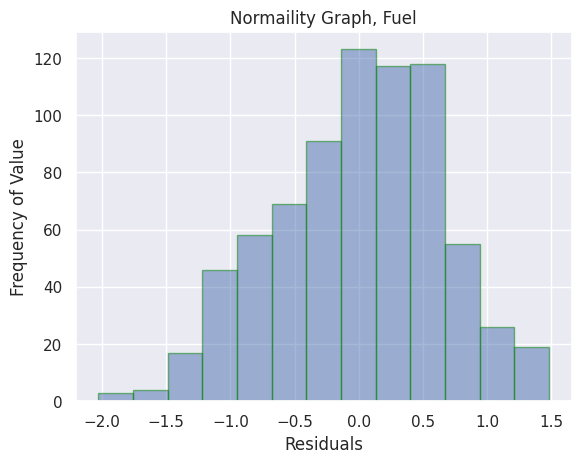

In [1194]:
import matplotlib.pyplot as plt
plt.hist(Residuals_vals, bins=13, edgecolor='Green', alpha=0.5)
plt.title("Normaility Graph, Fuel")
plt.xlabel("Residuals")
plt.ylabel("Frequency of Value")
plt.show()